In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import wb
import matplotlib.pyplot as plt

### Download the Data

In [2]:
GDP_Current_LCU = 'NY.GDP.MKTP.CN'
GDP_Constant_LCU = 'NY.GDP.MKTP.KN'
BroadMoney = 'FM.LBL.BMNY.CN'
Inflation_GDP_Deflactor = 'NY.GDP.DEFL.KD.ZG'

indicators = [GDP_Current_LCU, GDP_Constant_LCU, BroadMoney, Inflation_GDP_Deflactor]
cols = {'NY.GDP.MKTP.CN': 'GDP_Current','NY.GDP.MKTP.KN': 'GDP_Constant', 'FM.LBL.BMNY.CN': 'Broad_Money', 'NY.GDP.DEFL.KD.ZG': 'Inflation' }

In [3]:
import warnings
warnings.filterwarnings("ignore")

for id in indicators:
    df = wb.download(indicator=id, country='ARG', start=1960, end=2023)
    df = df.reset_index()
    df.rename(columns=cols, inplace=True)
    
    archivo_csv = f'data/{id}.csv'
    
   
    df.to_csv(archivo_csv, index=False)
    
    print(f'Se ha guardado "{archivo_csv}"')

Se ha guardado "data/NY.GDP.MKTP.CN.csv"
Se ha guardado "data/NY.GDP.MKTP.KN.csv"
Se ha guardado "data/FM.LBL.BMNY.CN.csv"
Se ha guardado "data/NY.GDP.DEFL.KD.ZG.csv"


In [4]:
archivos = ['data/NY.GDP.MKTP.CN.csv', 'data/NY.GDP.MKTP.KN.csv', 'data/FM.LBL.BMNY.CN.csv', 'data/NY.GDP.DEFL.KD.ZG.csv']
names = ['GDP_N', 'GDP_R', 'M', 'Inf']


for archivo, name in zip(archivos, names):
   
    df = pd.read_csv(archivo)
    df.drop(columns=['country'], inplace=True)
   
    globals()[f'df_{name}'] = df

In [5]:
df = df_GDP_N.merge(df_GDP_R, on=['year'], how='inner').merge(df_M, on=['year'], how='inner').merge(df_Inf, on=['year'], how='inner')

### Take a Quick Look at the Data Structure

In [6]:
df = df.set_index('year').sort_index()
df.head()

,GDP_Current,GDP_Constant,Broad_Money,Inflation
year,,,,
1960,0.131509,182932009390,0.0278,NaN
1961,0.166807,192861271430,0.0277,20.310698
1962,0.213136,191218051890,0.0305,28.871842
1963,0.253471,181067821330,0.0406,25.591154
1964,0.359472,199410530600,0.0574,28.774617


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 1960 to 2023
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP_Current   64 non-null     float64
 1   GDP_Constant  64 non-null     int64  
 2   Broad_Money   64 non-null     float64
 3   Inflation     63 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.5 KB


- There are 63 instances
- There is an inflation missing value
- All types are either int or float

In [8]:
df.describe()

,GDP_Current,GDP_Constant,Broad_Money,Inflation
count,6.400000e+01,6.400000e+01,6.400000e+01,63.000000
mean,6.745902e+12,4.357923e+11,2.223707e+12,160.504985
std,2.654223e+13,1.757459e+11,9.349964e+12,466.089242
min,1.315089e-01,1.810678e+11,2.770000e-02,-3.561096
25%,8.160482e+01,3.119506e+11,1.570000e+01,15.158787
50%,2.037680e+11,3.699366e+11,2.506350e+10,28.871842
75%,9.601467e+11,6.121403e+11,2.549766e+11,100.533395
max,1.914050e+14,7.263899e+11,6.892420e+13,3046.091152


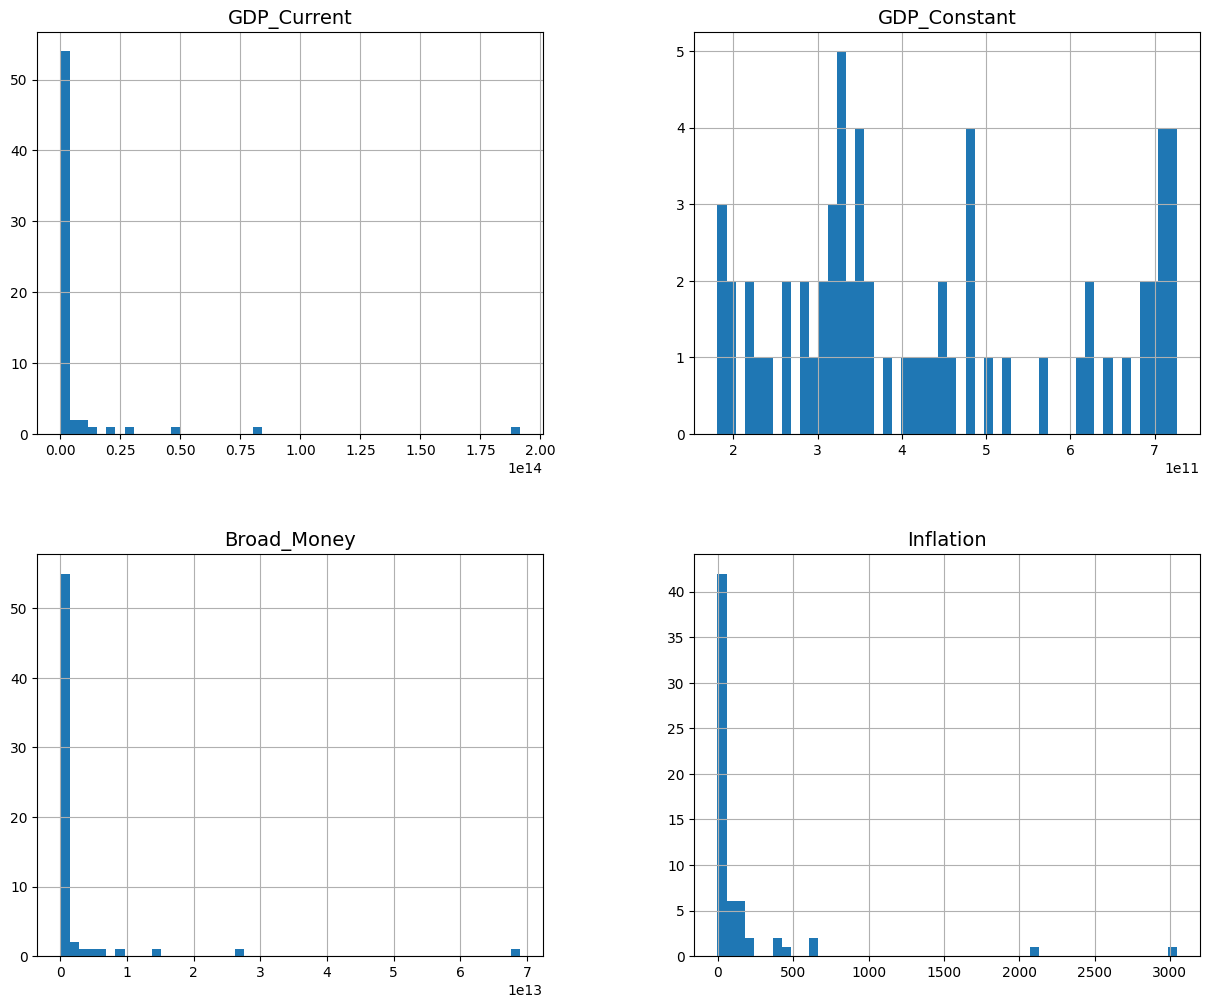

In [9]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15,12))
plt.show()

- GDP_Current, Broad_Money and Inflation are skewed to the right with somewhat fat tails

### Create a Test Set

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

### Discover and Visualize the Data to Gain Insights

In [11]:
monetary = train_set.copy()

#### Looking for Correlations

In [12]:
corr_matrix = monetary.corr(numeric_only=True)

In [13]:
corr_matrix["Inflation"].sort_values(ascending=False)

Inflation       1.000000
GDP_Constant   -0.122450
GDP_Current    -0.180335
Broad_Money    -0.188372
Name: Inflation, dtype: float64

In [14]:
columns_to_calculate = ['GDP_Current', 'GDP_Constant', 'Broad_Money']

for col in columns_to_calculate:
    monetary[f'{col}_arc'] = monetary[col].pct_change()

In [15]:
corr_matrix = monetary.corr(numeric_only=True)
corr_matrix["Inflation"].sort_values(ascending=False)

Inflation           1.000000
GDP_Current_arc     0.999447
Broad_Money_arc     0.980737
GDP_Constant       -0.122450
GDP_Current        -0.180335
Broad_Money        -0.188372
GDP_Constant_arc   -0.352872
Name: Inflation, dtype: float64

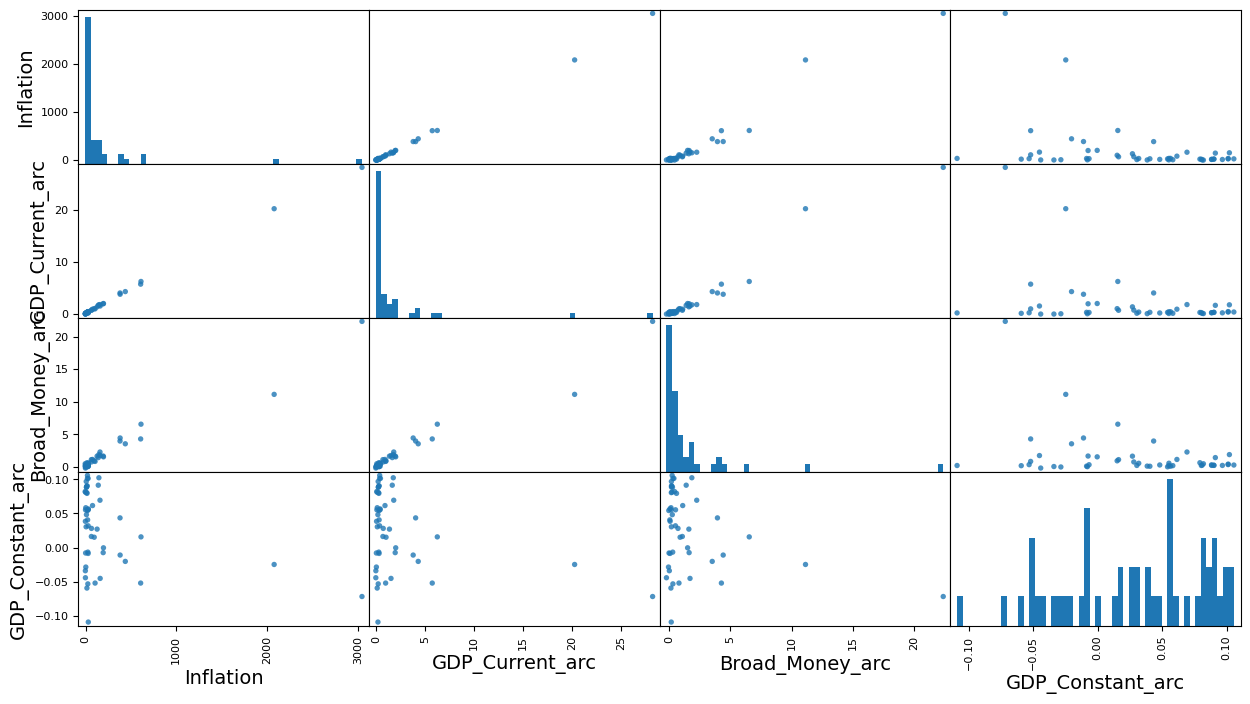

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["Inflation", "GDP_Current_arc" , "Broad_Money_arc", "GDP_Constant_arc"]
scatter_matrix(monetary[attributes], figsize=(15, 8), marker='.', hist_kwds={'bins': 50}, s=60, alpha=0.8)
plt.show()

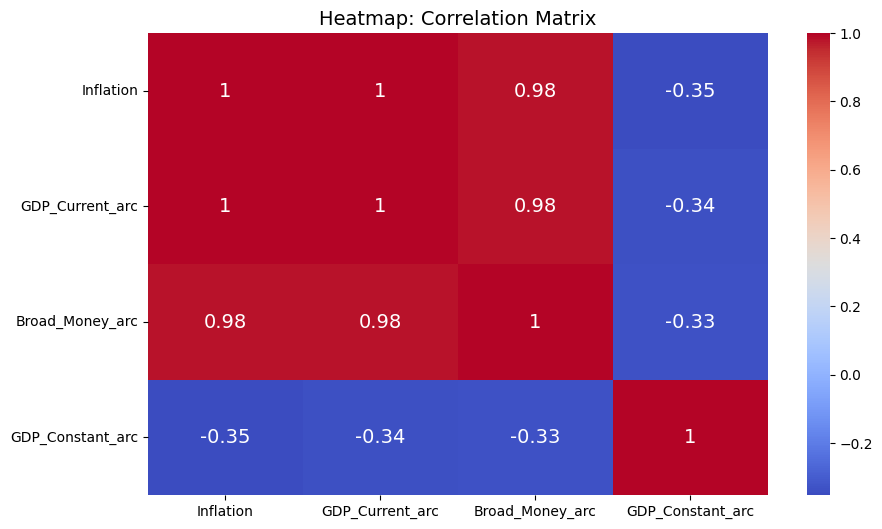

In [17]:
import seaborn as sns

correlation_matrix = monetary[attributes].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')

plt.show()

### Prepare the Data for Machine Learning Algorithms

In [18]:
def drop_missing_values(X):
    return X.dropna()

def log_difference(X):
    diff = np.diff(X, axis=0)
    padded_diff = np.vstack([np.full((1, X.shape[1]), np.nan), diff])
    return padded_diff


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    FunctionTransformer(log_difference, feature_names_out="one-to-one"),
    SimpleImputer(strategy="median")
)
    

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     FunctionTransformer(lambda x: np.log(np.maximum(x, 1e-6)), feature_names_out="one-to-one"))
                                   
preprocessing = ColumnTransformer([
        ("log_diff", log_pipeline, ["GDP_Current", "GDP_Constant", "Broad_Money" ])
        ],
    remainder=default_num_pipeline)  

In [32]:
mean_inflation = train_set["Inflation"].mean()

In [33]:
monetary = train_set.drop("Inflation", axis=1)
monetary_labels = train_set["Inflation"].copy().fillna(mean_inflation)

In [34]:
monetary.shape

(51, 3)

In [35]:
monetary_prepared = preprocessing.fit_transform(monetary)

In [36]:
monetary_prepared.shape

(51, 3)

In [30]:
preprocessing.get_feature_names_out()

array(['log_diff__GDP_Current', 'log_diff__GDP_Constant',
       'log_diff__Broad_Money'], dtype=object)

### Select and Train a Model

#### Training and Evaluating on the Training Set

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(monetary, monetary_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('functiontransformer',
                                                              FunctionTransformer(feature_names_out='one-to-one',
                                                                                  func=<function <lambda> at 0x11efc3100>))]),
                                   transformers=[('log_diff',
                                                  Pipeline(steps=[('simpleimputer-1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functi...ansformer-1',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('functiontransformer-2',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_difference at 0x11eac9760>)),
                                                                  ('simpleimputer-2',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GDP_Current',
                                                   'GDP_Constant',
                                                   'Broad_Money'])])),
                ('linearregression', LinearRegression())])

In [38]:
monetary_predictions = lin_reg.predict(monetary)

In [39]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(monetary_labels, monetary_predictions)
lin_rmse

246.12782685147073

In [40]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(monetary, monetary_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('functiontransformer',
                                                              FunctionTransformer(feature_names_out='one-to-one',
                                                                                  func=<function <lambda> at 0x11efc3100>))]),
                                   transformers=[('log_diff',
                                                  Pipeline(steps=[('simpleimputer-1',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functi...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('functiontransformer-2',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_difference at 0x11eac9760>)),
                                                                  ('simpleimputer-2',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GDP_Current',
                                                   'GDP_Constant',
                                                   'Broad_Money'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [41]:
monetary_predictions = tree_reg.predict(monetary)

tree_rmse = root_mean_squared_error(monetary_labels, monetary_predictions)
tree_rmse

0.0

#### Better Evaluation Using Cross-Validation

In [42]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, monetary, monetary_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [43]:
pd.Series(tree_rmses).describe()

count      10.000000
mean      198.666539
std       378.328233
min        22.489127
25%        72.131505
50%        82.228596
75%       106.380682
max      1272.924481
dtype: float64

In [44]:
lin_rmses = -cross_val_score(lin_reg, monetary, monetary_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count      10.000000
mean      279.966573
std       431.796961
min        56.105950
25%       106.969513
50%       156.936099
75%       205.288053
max      1499.975755
dtype: float64

In [45]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, monetary, monetary_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [46]:
pd.Series(forest_rmses).describe()

count      10.000000
mean      200.235770
std       387.136112
min        10.655118
25%        51.804656
50%        63.592180
75%       125.283778
max      1292.375317
dtype: float64

### Fine-Tune Your Model